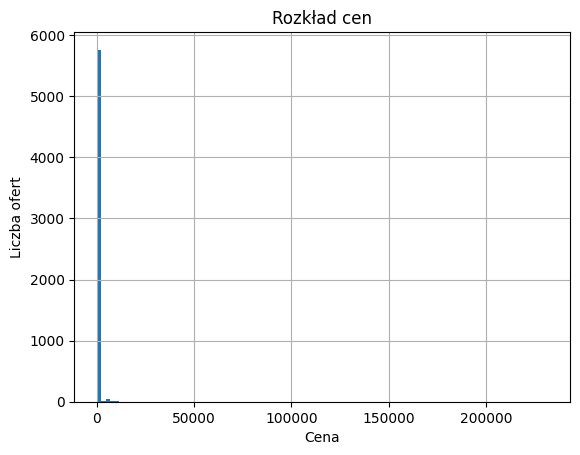


Korelacje z ceną:
 price                                        1.000000
accommodates                                 0.450400
acc_bed                                      0.374243
room_type_Entire home/apt                    0.366384
property_type_Entire rental unit             0.336411
                                               ...   
bathroom_type_shared                        -0.307314
room_type_Private room                      -0.374593
property_type_Private room in rental unit   -0.411867
property_type_Entire chalet                       NaN
property_type_Room in bed and breakfast           NaN
Name: price, Length: 192, dtype: float64
MAE:  53.54
RMSE: 91.18
R²:   0.5180


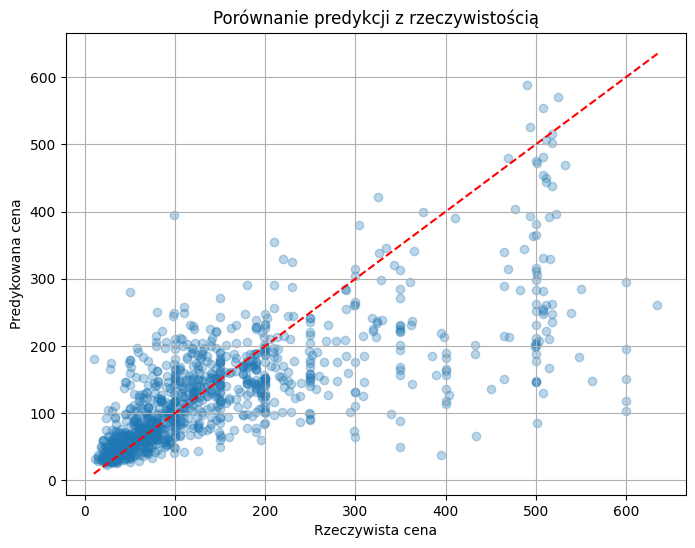

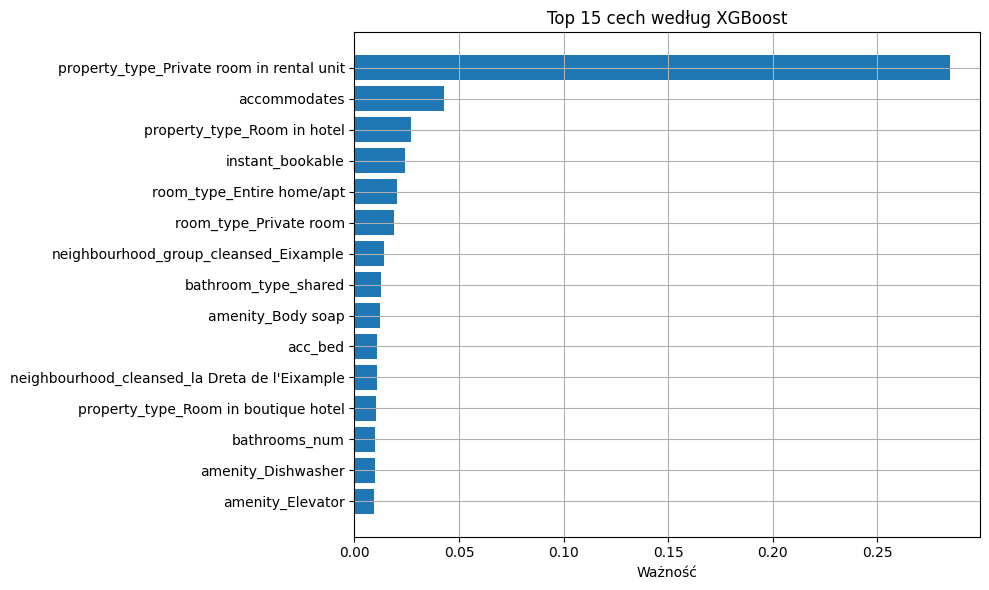

In [1]:
# Importy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Wczytaj dane
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df.drop(columns=["id"], inplace=True)

# Feature engineering – interakcje
df["acc_bed"] = df["accommodates"] * df["bedrooms"]

# Histogram cen
plt.hist(df["price"], bins=100)
plt.xlabel("Cena")
plt.ylabel("Liczba ofert")
plt.title("Rozkład cen")
plt.grid(True)
plt.show()

# Usunięcie outlierów (5% największych wartości)
df = df[df["price"] < df["price"].quantile(0.95)]

# Korelacje cech numerycznych z price
correlations = df.corr(numeric_only=True)["price"].sort_values(ascending=False)
print("\nKorelacje z ceną:\n", correlations)

# Log-transformacja ceny
df["price"] = np.log1p(df["price"])

# Usunięcie rzadkich cech kategorycznych
for col in df.select_dtypes(include='object').columns:
    freq = df[col].value_counts()
    rare = freq[freq < 10].index
    df[col] = df[col].replace(rare, 'Other')

# One-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Przygotowanie danych
X = df.drop(columns=["price"])
y = df["price"]

# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiory uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# GridSearch do optymalizacji hiperparametrów
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(XGBRegressor(random_state=42, early_stopping_rounds=10, eval_metric='rmse'), param_grid, 
                    cv=3, scoring='r2', verbose=0)
grid.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
model = grid.best_estimator_

# Zapisz model i scaler
joblib.dump(model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Predykcja
y_pred = model.predict(X_test)

# Odwrócenie log-transformacji
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

# Metryki
mae = mean_absolute_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
r2 = r2_score(y_test_exp, y_pred_exp)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Wykres porównania predykcji do rzeczywistych cen
plt.figure(figsize=(8, 6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.3)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], '--r')
plt.xlabel("Rzeczywista cena")
plt.ylabel("Predykowana cena")
plt.title("Porównanie predykcji z rzeczywistością")
plt.grid(True)
plt.show()

# Ważność cech
importances = model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Ważność")
plt.title("Top 15 cech według XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()
